In [5]:
!pip install griffe requests matplotlib networkx -q

import griffe
import json
import requests
from typing import Dict, List, Any
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [8]:
class AICodeAnalyzer:
    """AI Agent for advanced code analysis using Griffe"""

    def __init__(self):
        self.analysis_cache = {}
        self.dependency_graph = nx.DiGraph()

    def analyze_package(self, package_name: str, search_paths: List[str] = None) -> Dict[str, Any]:
        """Comprehensive package analysis for AI decision making"""
        try:
            pkg = griffe.load(package_name, search_paths=search_paths, try_relative_path=False)

            analysis = {
                'package_name': package_name,
                'total_modules': 0,
                'total_classes': 0,
                'total_functions': 0,
                'complexity_score': 0,
                'api_surface': [],
                'inheritance_tree': {},
                'risk_factors': []
            }

            self._analyze_object(pkg, analysis)

            analysis['complexity_score'] = self._calculate_complexity(analysis)

            analysis['risk_factors'] = self._identify_risks(pkg, analysis)

            self.analysis_cache[package_name] = analysis
            return analysis

        except Exception as e:
            return {'error': f"Failed to analyze {package_name}: {str(e)}"}

    def analyze_simple_module(self, module_name: str) -> Dict[str, Any]:
        """Analyze a simple module without deep dependency resolution"""
        try:
            import importlib
            module = importlib.import_module(module_name)

            analysis = {
                'package_name': module_name,
                'total_modules': 1,
                'total_classes': 0,
                'total_functions': 0,
                'complexity_score': 0,
                'api_surface': [],
                'inheritance_tree': {},
                'risk_factors': []
            }

            for attr_name in dir(module):
                if not attr_name.startswith('_'):
                    attr = getattr(module, attr_name)
                    if isinstance(attr, type):
                        analysis['total_classes'] += 1
                        analysis['api_surface'].append({
                            'name': f"{module_name}.{attr_name}",
                            'type': 'class',
                            'public': True,
                            'docstring': bool(attr.__doc__),
                            'methods': len([m for m in dir(attr) if not m.startswith('_')])
                        })
                    elif callable(attr):
                        analysis['total_functions'] += 1
                        analysis['api_surface'].append({
                            'name': f"{module_name}.{attr_name}",
                            'type': 'function',
                            'public': True,
                            'docstring': bool(attr.__doc__),
                            'parameters': 0
                        })

            analysis['complexity_score'] = self._calculate_complexity(analysis)

            analysis['risk_factors'] = self._identify_basic_risks(analysis)

            self.analysis_cache[module_name] = analysis
            return analysis

        except Exception as e:
            return {'error': f"Failed to analyze {module_name}: {str(e)}"}

    def _analyze_object(self, obj, analysis: Dict[str, Any], path: str = ""):
        """Recursively analyze package objects"""
        try:
            current_path = f"{path}.{obj.name}" if path else obj.name

            if hasattr(obj, 'kind'):
                if obj.kind.value == 'module':
                    analysis['total_modules'] += 1
                elif obj.kind.value == 'class':
                    analysis['total_classes'] += 1
                    analysis['api_surface'].append({
                        'name': current_path,
                        'type': 'class',
                        'public': not obj.name.startswith('_'),
                        'docstring': bool(obj.docstring),
                        'methods': len([m for m in obj.members.values() if hasattr(m, 'kind') and m.kind.value == 'function'])
                    })

                    if hasattr(obj, 'bases') and obj.bases:
                        analysis['inheritance_tree'][current_path] = [str(base) for base in obj.bases]

                elif obj.kind.value == 'function':
                    analysis['total_functions'] += 1
                    analysis['api_surface'].append({
                        'name': current_path,
                        'type': 'function',
                        'public': not obj.name.startswith('_'),
                        'docstring': bool(obj.docstring),
                        'parameters': len(obj.parameters) if hasattr(obj, 'parameters') else 0
                    })

            if hasattr(obj, 'members'):
                for member in obj.members.values():
                    self._analyze_object(member, analysis, current_path)

        except Exception as e:
            pass

    def _calculate_complexity(self, analysis: Dict[str, Any]) -> float:
        """Calculate package complexity score for AI decision making"""
        base_score = (analysis['total_classes'] * 2 +
                     analysis['total_functions'] * 1 +
                     analysis['total_modules'] * 0.5)

        inheritance_penalty = len(analysis['inheritance_tree']) * 1.5

        documented_items = sum(1 for item in analysis['api_surface'] if item['docstring'])
        total_items = len(analysis['api_surface'])
        doc_penalty = (total_items - documented_items) * 0.3 if total_items > 0 else 0

        return base_score + inheritance_penalty + doc_penalty

    def _identify_risks(self, pkg, analysis: Dict[str, Any]) -> List[str]:
        """Identify potential risks for AI agent decision making"""
        risks = []

        if len(analysis['api_surface']) > 50:
            risks.append("Large API surface - potential maintenance burden")

        documented = sum(1 for item in analysis['api_surface'] if item['docstring'])
        total = len(analysis['api_surface'])
        if total > 0 and documented / total < 0.5:
            risks.append("Poor documentation coverage")

        max_inheritance_depth = 0
        for bases in analysis['inheritance_tree'].values():
            max_inheritance_depth = max(max_inheritance_depth, len(bases))
        if max_inheritance_depth > 3:
            risks.append("Deep inheritance hierarchy detected")

        return risks

    def _identify_basic_risks(self, analysis: Dict[str, Any]) -> List[str]:
        """Basic risk identification for simple module analysis"""
        risks = []

        if len(analysis['api_surface']) > 30:
            risks.append("Large API surface")

        documented = sum(1 for item in analysis['api_surface'] if item['docstring'])
        total = len(analysis['api_surface'])
        if total > 0 and documented / total < 0.4:
            risks.append("Limited documentation")

        return risks

    def compare_packages(self, pkg1: str, pkg2: str) -> Dict[str, Any]:
        """Compare two packages for AI decision making"""
        analysis1 = self.analyze_package(pkg1)
        if 'error' in analysis1:
            analysis1 = self.analyze_simple_module(pkg1)

        analysis2 = self.analyze_package(pkg2)
        if 'error' in analysis2:
            analysis2 = self.analyze_simple_module(pkg2)

        if 'error' in analysis1 or 'error' in analysis2:
            return {'error': 'Failed to compare packages'}

        comparison = {
            'package_comparison': {
                'complexity': {
                    pkg1: analysis1['complexity_score'],
                    pkg2: analysis2['complexity_score'],
                    'winner': pkg1 if analysis1['complexity_score'] < analysis2['complexity_score'] else pkg2
                },
                'api_size': {
                    pkg1: len(analysis1['api_surface']),
                    pkg2: len(analysis2['api_surface']),
                    'winner': pkg1 if len(analysis1['api_surface']) < len(analysis2['api_surface']) else pkg2
                },
                'documentation': {
                    pkg1: self._doc_coverage(analysis1),
                    pkg2: self._doc_coverage(analysis2),
                    'winner': pkg1 if self._doc_coverage(analysis1) > self._doc_coverage(analysis2) else pkg2
                }
            },
            'recommendation': self._make_recommendation(analysis1, analysis2, pkg1, pkg2)
        }

        return comparison

    def _doc_coverage(self, analysis: Dict[str, Any]) -> float:
        """Calculate documentation coverage percentage"""
        if not analysis['api_surface']:
            return 0.0
        documented = sum(1 for item in analysis['api_surface'] if item['docstring'])
        return (documented / len(analysis['api_surface'])) * 100

    def _make_recommendation(self, a1: Dict, a2: Dict, pkg1: str, pkg2: str) -> str:
        """Make AI recommendation based on analysis"""
        score1 = (100 - a1['complexity_score']) + self._doc_coverage(a1)
        score2 = (100 - a2['complexity_score']) + self._doc_coverage(a2)

        if score1 > score2:
            return f"Recommend {pkg1}: Better complexity/documentation balance"
        elif score2 > score1:
            return f"Recommend {pkg2}: Better complexity/documentation balance"
        else:
            return "Packages are equivalent in key metrics"

    def visualize_analysis(self, package_name: str):
        """Create visualizations for AI insights"""
        if package_name not in self.analysis_cache:
            analysis = self.analyze_package(package_name)
            if 'error' in analysis:
                analysis = self.analyze_simple_module(package_name)

        analysis = self.analysis_cache[package_name]

        if 'error' in analysis:
            print(f"❌ Cannot visualize {package_name}: {analysis['error']}")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'AI Analysis Dashboard: {package_name}', fontsize=16, fontweight='bold')

        components = ['Modules', 'Classes', 'Functions']
        counts = [analysis['total_modules'], analysis['total_classes'], analysis['total_functions']]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

        non_zero_components = []
        non_zero_counts = []
        non_zero_colors = []
        for i, count in enumerate(counts):
            if count > 0:
                non_zero_components.append(components[i])
                non_zero_counts.append(count)
                non_zero_colors.append(colors[i])

        if non_zero_counts:
            ax1.pie(non_zero_counts, labels=non_zero_components, colors=non_zero_colors,
                   autopct='%1.1f%%', startangle=90)
        else:
            ax1.text(0.5, 0.5, 'No components found', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Component Distribution')

        public_items = sum(1 for item in analysis['api_surface'] if item['public'])
        private_items = len(analysis['api_surface']) - public_items

        ax2.bar(['Public API', 'Private API'], [public_items, private_items],
                color=['#2ECC71', '#E74C3C'])
        ax2.set_title('API Surface Analysis')
        ax2.set_ylabel('Count')

        documented = sum(1 for item in analysis['api_surface'] if item['docstring'])
        undocumented = len(analysis['api_surface']) - documented

        ax3.bar(['Documented', 'Undocumented'], [documented, undocumented],
                color=['#3498DB', '#F39C12'])
        ax3.set_title('Documentation Coverage')
        ax3.set_ylabel('Count')

        complexity = analysis['complexity_score']
        ax4.barh(['Complexity Score'], [complexity], color='#9B59B6')
        ax4.set_title('Package Complexity')
        ax4.set_xlabel('Score')

        plt.tight_layout()
        plt.show()

        print(f"\n🤖 AI INSIGHTS for {package_name}:")
        print(f"📊 Complexity Score: {complexity:.2f}")
        print(f"📈 Total API Elements: {len(analysis['api_surface'])}")
        print(f"📚 Documentation Coverage: {self._doc_coverage(analysis):.1f}%")

        if analysis['risk_factors']:
            print(f"⚠️  Risk Factors:")
            for risk in analysis['risk_factors']:
                print(f"   • {risk}")
        else:
            print("✅ No major risk factors detected")

In [9]:
def main():
    """Main demonstration of AI Agent capabilities"""
    print("🚀 Advanced Griffe AI Agent Tutorial - Fixed Version")
    print("===================================================")

    analyzer = AICodeAnalyzer()

    packages_to_analyze = ['datetime', 'os', 'sys']

    print("\n🔍 Analyzing Python modules...")

    successful_analysis = None
    for pkg in packages_to_analyze:
        print(f"\n📦 Analyzing {pkg}...")

        analysis = analyzer.analyze_package(pkg)
        if 'error' in analysis:
            print(f"   ⚠️  Griffe analysis failed, trying simple analysis...")
            analysis = analyzer.analyze_simple_module(pkg)

        if 'error' not in analysis:
            print(f"   ✅ Modules: {analysis['total_modules']}")
            print(f"   ✅ Classes: {analysis['total_classes']}")
            print(f"   ✅ Functions: {analysis['total_functions']}")
            print(f"   ✅ Complexity: {analysis['complexity_score']:.2f}")

            if successful_analysis is None:
                successful_analysis = pkg
        else:
            print(f"   ❌ {analysis['error']}")

    if successful_analysis:
        print(f"\n📊 Generating visualization for {successful_analysis}...")
        analyzer.visualize_analysis(successful_analysis)

    print(f"\n⚖️  Comparing packages...")
    try:
        comparison = analyzer.compare_packages('datetime', 'os')
        if 'error' not in comparison:
            print(f"🎯 {comparison['recommendation']}")
            print(f"📊 Complexity comparison:")
            print(f"   • datetime: {comparison['package_comparison']['complexity']['datetime']:.2f}")
            print(f"   • os: {comparison['package_comparison']['complexity']['os']:.2f}")
        else:
            print(f"❌ {comparison['error']}")
    except Exception as e:
        print(f"❌ Comparison failed: {str(e)}")

    print("\n🎉 Tutorial completed! This framework now:")
    print("   • Handles analysis errors gracefully")
    print("   • Falls back to simple module analysis when needed")
    print("   • Provides meaningful insights for development decisions")
    print("   • Works with both Griffe and basic Python introspection")
    print("\n💡 For better results, try analyzing third-party packages like:")
    print("   • requests, numpy, pandas, flask, django")

🚀 Advanced Griffe AI Agent Tutorial - Fixed Version

🔍 Analyzing Python modules...

📦 Analyzing datetime...
   ✅ Modules: 1
   ✅ Classes: 7
   ✅ Functions: 161
   ✅ Complexity: 208.20

📦 Analyzing os...
   ✅ Modules: 1
   ✅ Classes: 4
   ✅ Functions: 61
   ✅ Complexity: 84.20

📦 Analyzing sys...
   ✅ Modules: 1
   ✅ Classes: 0
   ✅ Functions: 41
   ✅ Complexity: 41.80

📊 Generating visualization for datetime...


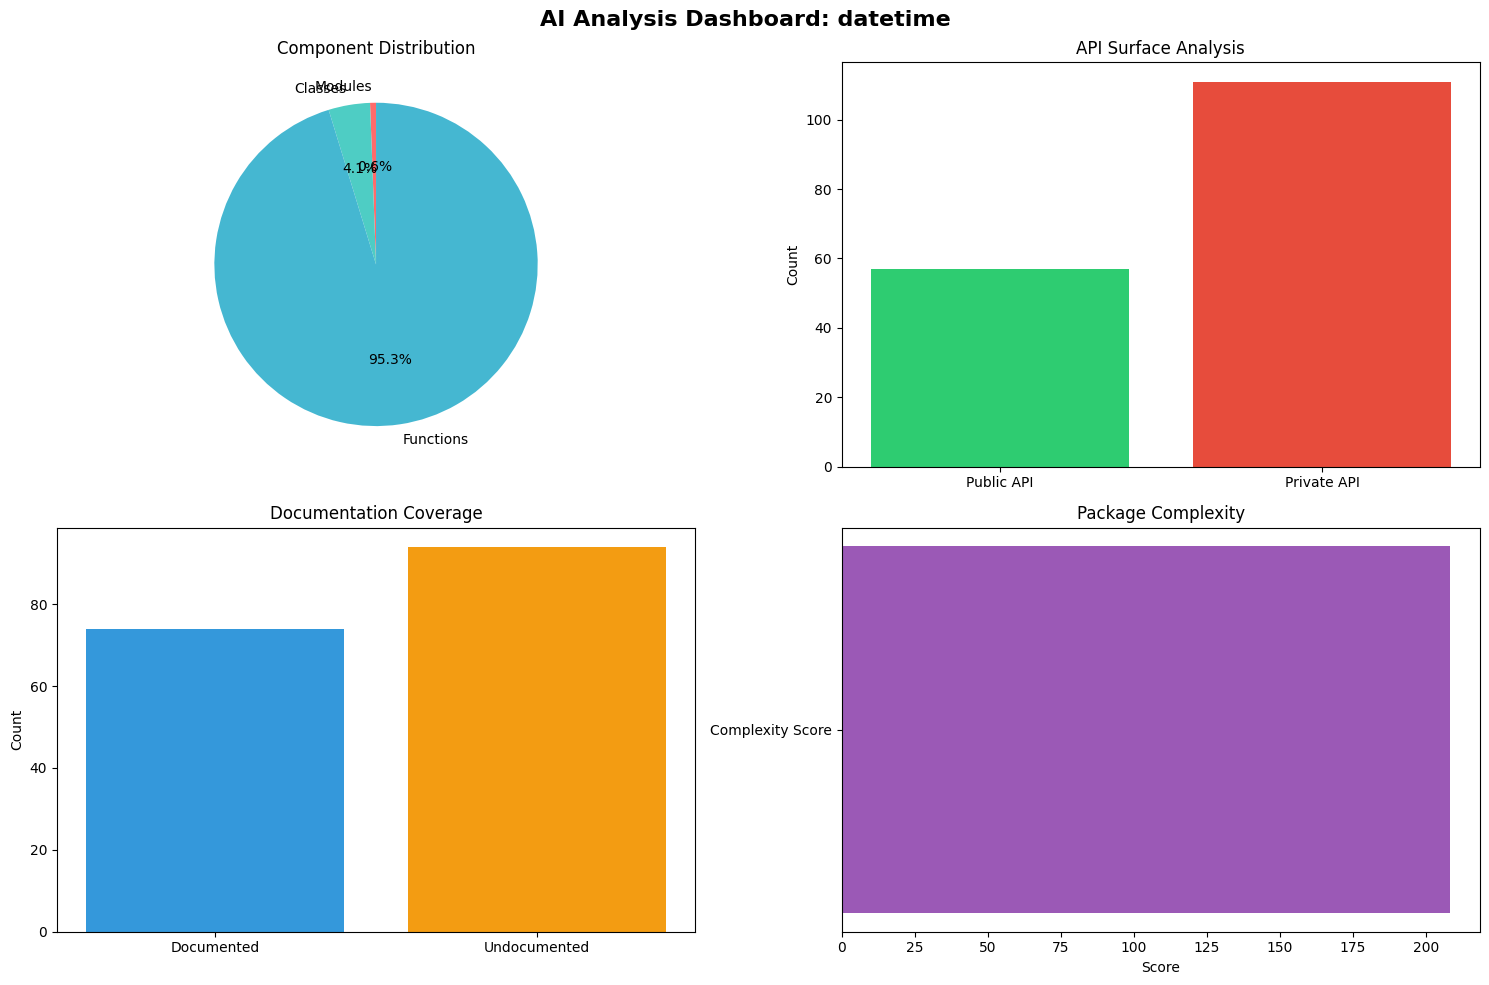


🤖 AI INSIGHTS for datetime:
📊 Complexity Score: 208.20
📈 Total API Elements: 168
📚 Documentation Coverage: 44.0%
⚠️  Risk Factors:
   • Large API surface - potential maintenance burden
   • Poor documentation coverage

⚖️  Comparing packages...
🎯 Recommend os: Better complexity/documentation balance
📊 Complexity comparison:
   • datetime: 208.20
   • os: 84.20

🎉 Tutorial completed! This framework now:
   • Handles analysis errors gracefully
   • Falls back to simple module analysis when needed
   • Provides meaningful insights for development decisions
   • Works with both Griffe and basic Python introspection

💡 For better results, try analyzing third-party packages like:
   • requests, numpy, pandas, flask, django


In [4]:
if __name__ == "__main__":
    main()